In [ ]:
#from hybridpredictmaize22.hybridpredictmaize22.snpCompression import *
from hybridpredictmaize22.GEMlearn import *
from hybridpredictmaize22.GEMdataset import *
from hybridpredictmaize22.snpCompression import *

from pathlib import Path
import os

import allel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from sklearn.decomposition import PCA



from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim

import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
from warnings import warn


In [ ]:
test_split = 2019
path_snps = Path('./data/snpCompress/')
data_path = Path('./data/Training_Data/')
path_train_weatherTable =data_path/'4_Training_Weather_Data_2014_2021.csv'
path_train_yieldTable = data_path/'1_Training_Trait_Data_2014_2021.csv'
snp_compression = 'PCS_100'
batch_size = 64

In [ ]:
path_train_yieldTable

Path('data/Training_Data/1_Training_Trait_Data_2014_2021.csv')

In [ ]:
!pwd

/mnt/c/Users/cltng/OneDrive/Documents/Projects/hybridpredictmaize22/dev_nbs


In [ ]:
snp_data = collect_snps(Path('./data/snpCompress/PCS_50')) # Read in the SNP profiles
yield_data = pd.read_csv(path_train_yieldTable) # Read in trait data 
yield_data = yield_data[yield_data['Yield_Mg_ha'].notnull()] #Remove plots w/ missing yields
weather_data = pd.read_csv(path_train_weatherTable) # Read in Weather Data
weather_data['Year'] = [x.split('_')[1] for x in weather_data['Env']] #Store Year in a new column
#removes yield data where no weather data
setYield = set(yield_data['Env'])
setWeather = set(weather_data['Env'])
only_yield = setYield - setWeather
only_weather = setWeather - setYield
yield_data = yield_data.iloc[[x not in only_yield for x in yield_data['Env']],:]
#removes yield data where no genotype data
setSNP = set(snp_data[0])
setYield = set(yield_data['Hybrid'])
only_yield = setYield - setSNP
yield_data = yield_data.iloc[[x not in only_yield for x in yield_data['Hybrid']],:]

weather_data = remove_leapdays(weather_data)
weather_data = weather_data.reset_index()
yield_data=yield_data.sample(frac=1)
yield_data = yield_data.reset_index()

In [ ]:
batch_size = 32


gem = GEM(test_split)
gem.Y = YT(yield_data, test_split)
gem.W = WT(weather_data, test_split)
gem.SNP = snp_data

tr_ds = GemDataset(gem.W.Tr, gem.Y.Tr, gem.SNP)
te_ds = GemDataset(gem.W.Te, gem.Y.Te, gem.SNP)

tr_dataloader = DataLoader(tr_ds, batch_size=batch_size, shuffle=True)
te_dataloader = DataLoader(te_ds, batch_size=batch_size, shuffle=False)

In [ ]:
class LazyMLP(torch.nn.Module):
    def __init__(self, hidden_list, dropout=0.1):
        super().__init__()
        self.dropout = dropout

        # Create a list of linear layers, with the correct input and output dimensions
        self.layers = torch.nn.ModuleList([nn.LazyLinear(x) for x in hidden_list])

    def forward(self, x):
        # Apply the dropout layer to the input
        x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)

        # Iterate through the linear layers, applying each one to the input
        for c, layer in enumerate(self.layers):
            x = layer(x)
            
            if c < len(self.layers)-1:
              x = torch.nn.functional.relu(x)  
            
            x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)

        return x


class NNEnsemble(torch.nn.Module):
  def __init__(self, hidden_list, models_list):
    super().__init__()

    self.models = models_list

    self.layers = nn.ModuleList()

    for x in hidden_list:
      self.layers.append(nn.LazyLinear(x))

    self.out = nn.LazyLinear(1)

  def forward(self,x):
    g,w = x
    g = self.models[0](g)
    w = self.models[1](w)

    w = w.view(w.shape[0], w.shape[1] * w.shape[2])
    x = torch.concat((g,w),axis=1)
    for c,layer in enumerate(self.layers):
      x = layer(x)
      if c < len(self.layers)-1:
        x = torch.nn.functional.relu(x) 
    return x


In [ ]:
gmodel = LazyMLP([200,100,10])
wmodel = LazyMLP([200,100,50])

model = NNEnsemble([100,50,1], [gmodel,wmodel])
model = model

opt = optim.SGD(model.parameters(), lr=.0005)
loss_func = F.mse_loss

tr_loss = [] 

te_loss = []

#for i in tqdm(range(len(tr_dataloader))):
for i in tqdm(range(5000)):
  
  #train loop
  y,g,w = next(iter(tr_dataloader))


  preds = model((g,w))
  preds = preds.squeeze(1)

  loss = loss_func(y,preds)

  loss.backward()
  opt.step()
  opt.zero_grad()

  tr_loss.append(loss.cpu().detach().numpy())

  #test loop  
  y,g,w = next(iter(te_dataloader))


  preds = model((g,w))
  preds = preds.squeeze(1)

  loss = loss_func(y,preds)

  te_loss.append(loss.cpu().detach().numpy())


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [15:06<00:00,  5.52it/s]


In [ ]:
def moving_average(arr, window_size):
    """Calculate the moving average of an array.
    
    Parameters:
    arr (np.ndarray): Input array with shape (n_samples,).
    window_size (int): Size of the moving window.
    
    Returns:
    np.ndarray: Moving average of the array, with shape (n_samples - window_size + 1,).
    """
    # Initialize a NumPy array to store the moving averages
    ma = np.zeros(len(arr) - window_size + 1)
    
    # Calculate the moving average
    for i in range(len(ma)):
        ma[i] = np.mean(arr[i:i+window_size])
        
    return ma


[<matplotlib.lines.Line2D>]

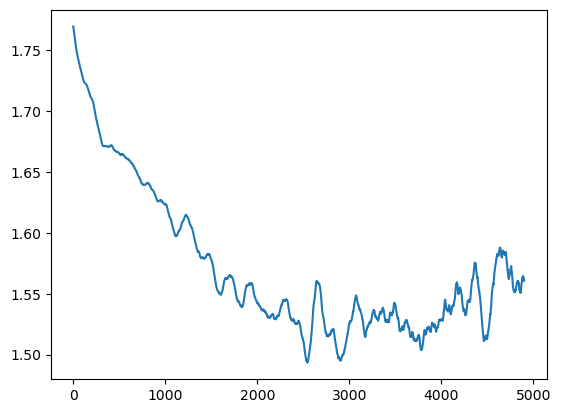

In [ ]:
plt.plot(moving_average(te_loss,100))

[<matplotlib.lines.Line2D>]

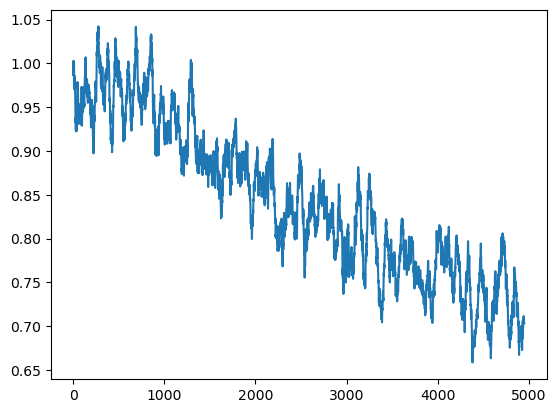

In [ ]:
plt.plot(moving_average(tr_loss,50))

In [ ]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        self.cb_ctx = partial(callback_ctx, self.callback)
        fc.store_attr()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

In [ ]:
class LazyMLP(torch.nn.Module):
    def __init__(self, hidden_list, dropout=0.1):
        super().__init__()
        self.dropout = dropout

        # Create a list of linear layers, with the correct input and output dimensions
        self.layers = torch.nn.ModuleList([nn.LazyLinear(x) for x in hidden_list])

    def forward(self, x):
        # Apply the dropout layer to the input
        x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)

        # Iterate through the linear layers, applying each one to the input
        for c, layer in enumerate(self.layers):
            x = layer(x)
            
            if c < len(self.layers)-1:
              x = torch.nn.functional.relu(x)  
            
            x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)

        return x

In [ ]:
model = LazyMLP([500,10,1])

/home/burbank/miniconda3/envs/fastai/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
class TrainCB(Callback):
    def predict(self, learn):
        learn.preds = learn.model(learn.batch[1])
    def get_loss(self, learn):
        learn.loss = learn.loss_func(learn.preds.squeeze(), learn.batch[0])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

In [ ]:
y,g,w = next(iter(tr_dataloader))

In [ ]:
learn = Learner(model, dls, cbs = [TrainCB()])

In [ ]:
learn.fit(1)

In [ ]:
learn.model(g)

tensor([[-0.4786],
        [-0.7224],
        [-0.5547],
        [-0.2708],
        [-0.3547],
        [-0.6647],
        [-0.3344],
        [-0.4365],
        [-0.4018],
        [-0.5777],
        [-0.6922],
        [-0.3879],
        [-0.3761],
        [-0.3826],
        [-0.3891],
        [-0.5835],
        [-0.1854],
        [-0.7585],
        [-0.5328],
        [-0.3824],
        [-0.4994],
        [-0.4323],
        [-0.5865],
        [-0.2736],
        [-0.3865],
        [-0.2693],
        [-0.7051],
        [-0.4338],
        [-0.5399],
        [-0.6746],
        [-0.6584],
        [-0.5087]], grad_fn=<AddmmBackward0>)